# Bernoulli TM implementation

## Loading libraries

In [1]:
# Load libraries
import logging
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.ops.indexing import Vindex

import torch
from torch.distributions import constraints

import numpy as np
import pandas as pd

from zzz_utils_plot import *
from tm_bern import *

import matplotlib.pyplot as plt

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

pyro.clear_param_store()
pyro.set_rng_seed(1234)

## Simulate

In [2]:
##### Simulation strategy
nCells = 500
nRegions = 800
nTopics = 3
a = torch.ones(nTopics) / 2

# Detection rate (coverage)
cov = dist.Beta(0.6, 2).sample([nRegions])# + 0.02
# Cell topics distribution
theta = dist.Dirichlet(a).sample([nCells])
# Topics region distribution
phi = LogitNormal(-1, 1).sample([nRegions, nTopics])
# Index matrix on nRegions x nCells
idx = torch.arange(0,nRegions).unsqueeze(1).repeat(1, nCells)
with pyro.plate(name='nCells', size=nCells):
    with pyro.plate(name='nRegions', size=nRegions): 
        z = pyro.sample(name='z', fn=dist.Categorical(theta))
        phi_z = Vindex(phi)[..., idx, z]
        phi_z = (phi_z.T * cov).T
        D = pyro.sample(name='w', fn=dist.Bernoulli(phi_z))
pyro.clear_param_store()
# Numpy array for PCA
D_np = D.detach().numpy().transpose()

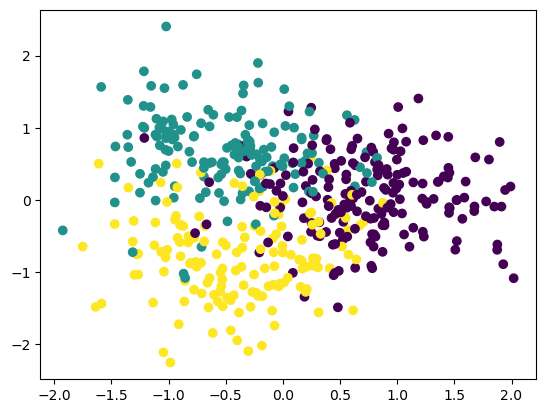

In [3]:
label = theta.detach().numpy()
from sklearn.decomposition import PCA
pca = PCA()
Xt = pca.fit_transform(D_np)
plot = plt.scatter(Xt[:,0], Xt[:,1], c = label.argmax(axis=1).tolist())
#plt.legend(handles=plot.legend_elements()[0], labels=list(winedata['target_names']))
plt.show()

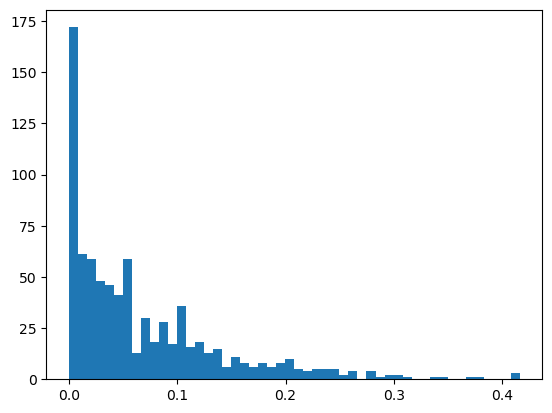

In [4]:
plt.hist(D.mean(axis=1), bins=50)
plt.show()

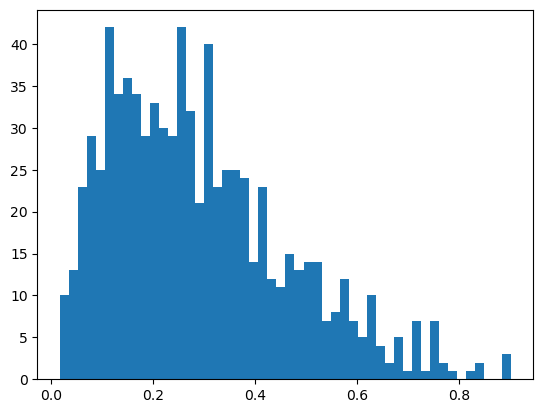

In [5]:
plt.hist(phi[:, 0], bins=50)
plt.show()

In [6]:
#pyro.set_rng_seed(123)
#trace = pyro.poutine.trace(tm_bern_model).get_trace()
#trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
#print(trace.format_shapes())

## Bernoulli topic model

Below we define the STM model with Pyro. Note that data D is a matrix of __nRegions x nCells__.

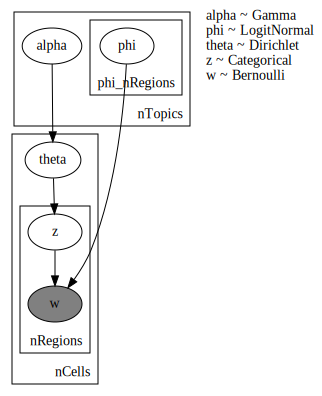

In [7]:
pyro.clear_param_store()
pyro.render_model(tm_bern_model, model_args=(D, nTopics), 
                  render_distributions=True, render_params=True)

## LDA guide (variational approximation)

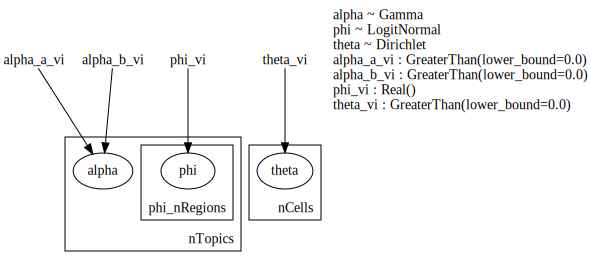

In [8]:
pyro.clear_param_store()
pyro.render_model(tm_bern_guide, model_args=(D, nTopics), 
                  render_distributions=True, render_params=True)

# Testing variational inference

In [9]:
# Filter to keep only regions with decent coverage
det_thr = 0.05

qc_peak_idx = np.where(np.array(D.mean(axis=1)) > det_thr)[0]
print('Number of peak regions passing QC threshold:', len(qc_peak_idx))
D_filt = D[qc_peak_idx, :]
print(D_filt.shape)

Number of peak regions passing QC threshold: 361
torch.Size([361, 500])


## Fit LDA 

To perform inference for TM Bernoulli with use ClippedAdam to optimize a 
__trace implementation of ELBO-based SVI__ ('TraceEnum_ELBO'), which supports exhaustive enumeration 
over discrete sample sites, in our case latent topic assignment __z__.

In [10]:
nTopics = 3
prior_alpha = 50
nSteps = 1000
lr = 0.1
seed = 123

pyro.set_rng_seed(seed)
pyro.clear_param_store()

# We'll fit using SVI.
logging.info("-" * 40)
logging.info("Fitting {} cells".format(D.shape[1]))

elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=2)
optim = pyro.optim.Adam({"lr": lr, 'weight_decay':0.01})
svi = pyro.infer.SVI(tm_bern_model, tm_bern_guide, optim, elbo)
losses = []

logging.info("Step\tLoss")
for step in range(nSteps):
    loss = svi.step(D=D_filt, nTopics=nTopics, prior_alpha=prior_alpha)
    if step % 100 == 0:
        logging.info("{: >5d}\t{}".format(step, loss))
    losses.append(loss)
logging.info("final loss = {}".format(loss))

     7309 ----------------------------------------
     7309 Fitting 500 cells
     7310 Step	Loss
     7373     0	135261.421875
    10114   100	69060.3671875
    12831   200	68522.109375
    15592   300	68789.421875
    18569   400	68323.5546875
    21819   500	68191.5390625
    25138   600	68156.7890625
    28228   700	68175.3515625
    31179   800	68143.4921875
    34110   900	68145.640625
    37471 final loss = 68134.3515625


Here we plot the elbo loss during optimisation

Text(0, 0.5, 'ELBO loss')

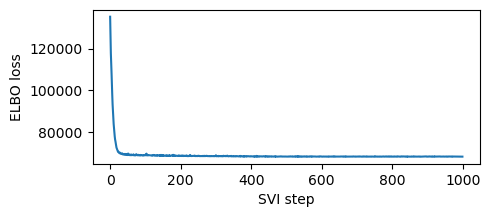

In [11]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

## Assessing inferred parameters

Below we show estimates of the inferred model parameters. To show this, here I am just taking a sample from the 
posterior fit (i.e. calling the guide with the optimized set of variational parameters). Surely this is not the optimal way to summarise the posterior fit. 

__However__, if I take multiple samples from the posterior and subseqently summarise the posterior samples (e.g. by median), due to label switching that occurs when sampling 
$\theta \sim Dir(\alpha)$, the posterior mode will be useless. 

__TODO__ 

1. Define a better way to summarize the posterior distribution from posterior samples. E.g. by fixing the label switching problem, post-hoc after sampling from the posterior (similar approach to mixture models).
2. Make posterior predictive checks.
3. Need to understand Pyro's `poutine`.


In [12]:
#for name, value in pyro.get_param_store().items():
#    print(name, pyro.param(name).data.cpu().numpy())

In [13]:
pyro.param("alpha_a_vi").detach() / pyro.param("alpha_b_vi").detach()

tensor([0.7153, 1.0335, 0.9332])

In [14]:
pyro.param("theta_vi").detach()[1:10, :]

tensor([[ 0.5916,  4.1700,  9.6028],
        [ 1.2875,  2.4293,  3.9470],
        [ 1.4708,  3.2329,  3.7670],
        [ 0.9812,  1.1971,  8.3027],
        [ 1.7935,  1.5939,  4.7603],
        [ 0.5491,  3.3979,  4.3917],
        [13.0594,  1.8871,  0.8883],
        [ 1.0681,  6.5121,  1.3741],
        [ 0.6835,  1.8348, 13.3656]])

In [15]:
# A single sample from the guide
post_sample = tm_bern_guide(D = D_filt, nTopics = nTopics)

In [16]:
theta[1:10, ] # first 10 cells prob assignments to each topic

tensor([[4.9788e-01, 4.9885e-01, 3.2776e-03],
        [4.7365e-01, 5.1582e-01, 1.0537e-02],
        [4.4656e-01, 1.4125e-01, 4.1219e-01],
        [1.2320e-01, 6.9227e-01, 1.8453e-01],
        [2.0929e-01, 7.4657e-01, 4.4137e-02],
        [2.1158e-01, 7.4771e-01, 4.0715e-02],
        [7.5394e-05, 1.0561e-03, 9.9887e-01],
        [7.4101e-01, 2.4607e-01, 1.2916e-02],
        [7.9263e-02, 8.2878e-01, 9.1962e-02]])

In [17]:
post_sample['theta'][1:10, :] # posterior theta

tensor([[0.0711, 0.4325, 0.4964],
        [0.1895, 0.5423, 0.2682],
        [0.3296, 0.3049, 0.3656],
        [0.2677, 0.1016, 0.6307],
        [0.3076, 0.0848, 0.6076],
        [0.0816, 0.1682, 0.7502],
        [0.6919, 0.2326, 0.0755],
        [0.1611, 0.6764, 0.1626],
        [0.0420, 0.0315, 0.9266]], grad_fn=<SliceBackward0>)

In [18]:
post_sample['phi'][1:10, :].detach().numpy() # posterior phi

array([[0.08063888, 0.0932791 , 0.09953123],
       [0.07407268, 0.07968166, 0.10229702],
       [0.04444139, 0.06137383, 0.05654122],
       [0.04165404, 0.09958034, 0.18646309],
       [0.19600795, 0.22873063, 0.20779884],
       [0.04054464, 0.15288657, 0.18451333],
       [0.09556989, 0.08654389, 0.4155667 ],
       [0.05661288, 0.11773024, 0.02480428],
       [0.1655908 , 0.15243131, 0.0791483 ]], dtype=float32)

In [19]:
phi[1:10, :]

tensor([[0.2112, 0.5104, 0.3275],
        [0.3013, 0.0921, 0.0323],
        [0.2666, 0.1490, 0.3460],
        [0.2860, 0.3974, 0.7011],
        [0.0535, 0.4961, 0.2119],
        [0.2411, 0.1527, 0.5706],
        [0.3881, 0.1458, 0.2170],
        [0.2406, 0.7077, 0.0340],
        [0.4077, 0.3065, 0.4938]])

### Topic-cell distribution plots

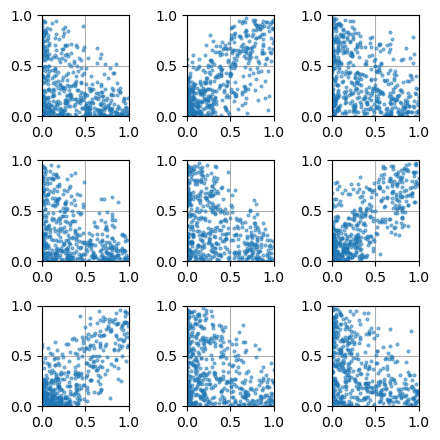

In [20]:
f = make_theta_comparison_plots(theta_true = theta, 
                                theta_infer = post_sample['theta'].detach().numpy())

### Topic-region distribution plots

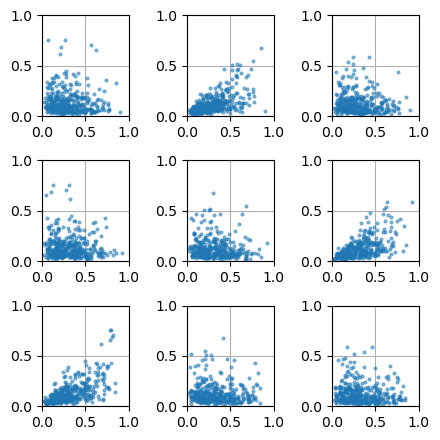

In [21]:
f = make_theta_comparison_plots(theta_true = phi[qc_peak_idx, :], 
                                theta_infer = post_sample['phi'].detach().numpy())